# Using the attribution runs to look at tropical Atlantic variability

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Get the names of all the hist-aer simulation files
file_names = os.listdir('cmip6.hist-aer.cvdp_data')

# Filter the file names to include only those with the .nc extension
aer_paths = [file_name for file_name in file_names if file_name.endswith('.nc')]
aer_paths

['ACCESS-CM2_r1i1p1f1.cvdp_data.1850-2014.nc',
 'ACCESS-CM2_r2i1p1f1.cvdp_data.1850-2014.nc',
 'ACCESS-CM2_r3i1p1f1.cvdp_data.1850-2014.nc',
 'ACCESS-ESM1-5_r1i1p1f1.cvdp_data.1850-2014.nc',
 'ACCESS-ESM1-5_r2i1p1f1.cvdp_data.1850-2014.nc',
 'ACCESS-ESM1-5_r3i1p1f1.cvdp_data.1850-2014.nc',
 'BCC-CSM2-MR_r1i1p1f1.cvdp_data.1850-2014.nc',
 'BCC-CSM2-MR_r2i1p1f1.cvdp_data.1850-2014.nc',
 'BCC-CSM2-MR_r3i1p1f1.cvdp_data.1850-2014.nc',
 'CanESM5_r10i1p1f1.cvdp_data.1850-2014.nc',
 'CanESM5_r10i1p2f1.cvdp_data.1850-2014.nc',
 'CanESM5_r11i1p1f1.cvdp_data.1850-2014.nc',
 'CanESM5_r11i1p2f1.cvdp_data.1850-2014.nc',
 'CanESM5_r12i1p1f1.cvdp_data.1850-2014.nc',
 'CanESM5_r12i1p2f1.cvdp_data.1850-2014.nc',
 'CanESM5_r13i1p1f1.cvdp_data.1850-2014.nc',
 'CanESM5_r13i1p2f1.cvdp_data.1850-2014.nc',
 'CanESM5_r14i1p1f1.cvdp_data.1850-2014.nc',
 'CanESM5_r14i1p2f1.cvdp_data.1850-2014.nc',
 'CanESM5_r15i1p1f1.cvdp_data.1850-2014.nc',
 'CanESM5_r15i1p2f1.cvdp_data.1850-2014.nc',
 'CanESM5_r1i1p1f1.cvdp_d

In [3]:
#Load in an example file to get some metadata
dataset = xr.open_dataset('cmip6.hist-aer.cvdp_data/'+aer_paths[0],decode_times=False)
dataset.time.attrs['calendar']='360_day'
dataset.time_mon1.attrs['calendar']='360_day'
dataset.time_mon2.attrs['calendar']='360_day'
dataset.time_mon3.attrs['calendar']='360_day'
dataset=xr.decode_cf(dataset,decode_times=True)
dataset=dataset.convert_calendar('proleptic_gregorian',align_on='year')
time=dataset.time
data = dataset['atlantic_nino']
data

<xarray.DataArray 'atlantic_nino' (time: 1980)>
[1980 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1850-01-15 1850-02-15 ... 2014-12-16
Attributes:
    comment_cvdp:  area average domain (-3:3N, -20:0E)
    units:         C
    long_name:     Atlantic Nino Index (monthly)

In [4]:
# Number of ensemble members
num_ensemble_members = len(aer_paths)
# Create a DataArray to hold all the ensemble members
# Dimensions of the data array
num_months = time.size
ensemble_member = xr.IndexVariable('ensemble_member', np.arange(num_ensemble_members))
aer_array = xr.DataArray(np.full((num_ensemble_members,num_months),np.nan), coords=[ensemble_member,time],
                          dims=['ensemble_member', 'time'])

# Print the information about the DataArray
aer_array


<xarray.DataArray (ensemble_member: 102, time: 1980)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * ensemble_member  (ensemble_member) int64 0 1 2 3 4 5 ... 96 97 98 99 100 101
  * time             (time) datetime64[ns] 1850-01-15 1850-02-15 ... 2014-12-16

In [5]:
# Fill up the dataArray
# Loop over each file
for i in range(1,num_ensemble_members-1):
    # Open the dataset using xarray
    dataset = xr.open_dataset('cmip6.hist-aer.cvdp_data/'+aer_paths[i],decode_times=False)
    dataset.time.attrs['calendar']='360_day'
    dataset.time_mon1.attrs['calendar']='360_day'
    dataset.time_mon2.attrs['calendar']='360_day'
    dataset.time_mon3.attrs['calendar']='360_day'
    dataset=xr.decode_cf(dataset,decode_times=True)
    dataset=dataset.convert_calendar('proleptic_gregorian',align_on='year')

    # Extract the variable of interest (assuming it's called 'data')
    aer_array[i,:] = dataset['atlantic_nino']


Text(0.5, 1.0, 'ATL3 in aerosol-driven runs (oC)')

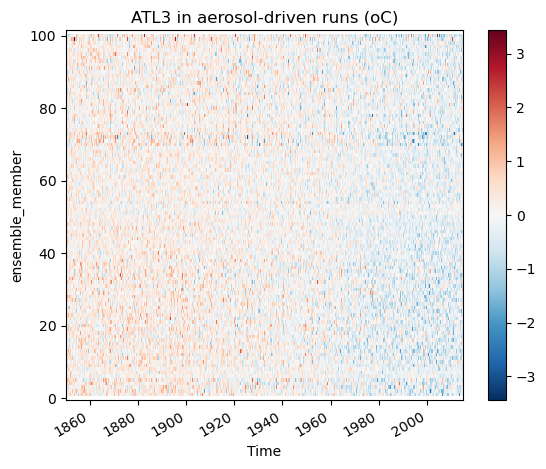

In [6]:
# convert to anomalies
aer_array.plot()
plt.title('ATL3 in aerosol-driven runs (oC)')

/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Aerosol-driven change in ATL3 std dev. (since 1850-99, oC^2)')

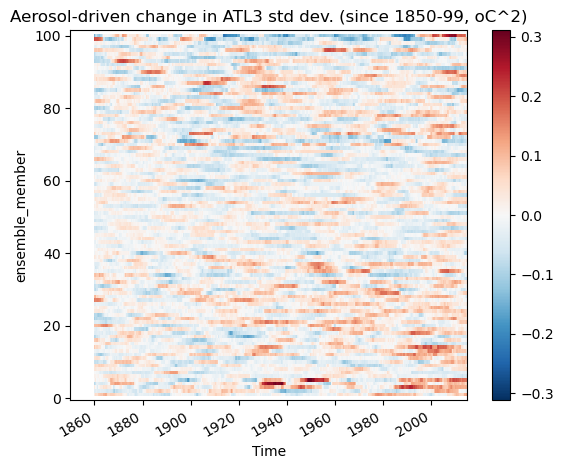

In [7]:
# Compute the running standard deviation
window_size = 120  # Number of months in the running window
running_std = aer_array.rolling(time=window_size).std()
# convert to anomalies
running_std=running_std-running_std.sel(time=slice('1850-01-01','1899-12-31')).mean(dim='time')
running_std.plot()
plt.title('Aerosol-driven change in ATL3 std dev. (since 1850-99, oC^2)')

In [6]:
# Get the names of all the hist-aer simulation files
file_names = os.listdir('cmip6.hist-ghg.cvdp_data')
# Filter the file names to include only those with the .nc extension
ghg_paths = [file_name for file_name in file_names if file_name.endswith('.nc')]
# Number of ensemble members
num_ensemble_members = len(aer_paths)
# Create a DataArray to hold all the ensemble members
# Dimensions of the data array
num_months = time.size
ensemble_member = xr.IndexVariable('ensemble_member', np.arange(num_ensemble_members))
ghg_array = xr.DataArray(np.full((num_ensemble_members,num_months),np.nan), coords=[ensemble_member,time],
                          dims=['ensemble_member', 'time'])
for i in range(1,num_ensemble_members-1):
    # Open the dataset using xarray
    dataset = xr.open_dataset('cmip6.hist-ghg.cvdp_data/'+ghg_paths[i],decode_times=False)
    dataset.time.attrs['calendar']='360_day'
    dataset.time_mon1.attrs['calendar']='360_day'
    dataset.time_mon2.attrs['calendar']='360_day'
    dataset.time_mon3.attrs['calendar']='360_day'
    dataset=xr.decode_cf(dataset,decode_times=True)
    dataset=dataset.convert_calendar('proleptic_gregorian',align_on='year')
    # Extract the variable of interest (assuming it's called 'data')
    ghg_array[i,:] = dataset['atlantic_nino']





In [7]:
# Write out arrays for later...
ghg_array.to_netcdf('atlantic_nino.cmip6.hist-GHG.cvdp_data.nc')
aer_array.to_netcdf('atlantic_nino.cmip6.hist-aer.cvdp_data.nc')

Text(0.5, 1.0, 'ATL3 in GHG-driven runs (oC)')

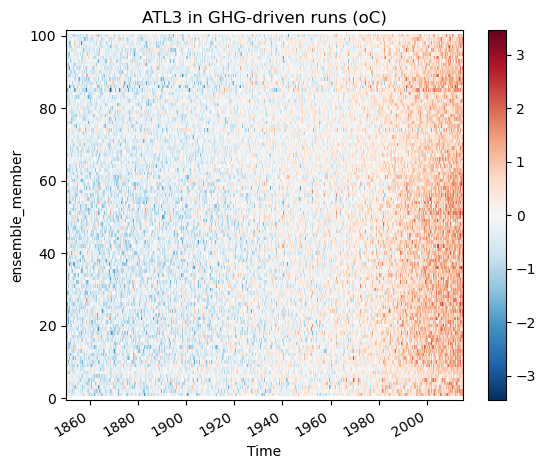

In [9]:
#Create some plots
#mean_state=ghg_array-ghg_array.sel(time=slice('1850-01-01','1899-12-31')).mean(dim='time')
mean_state=ghg_array
mean_state.plot()
plt.title('ATL3 in GHG-driven runs (oC)')

/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'GHG-driven change in ATL3 std dev. (since 1850-99, oC^2)')

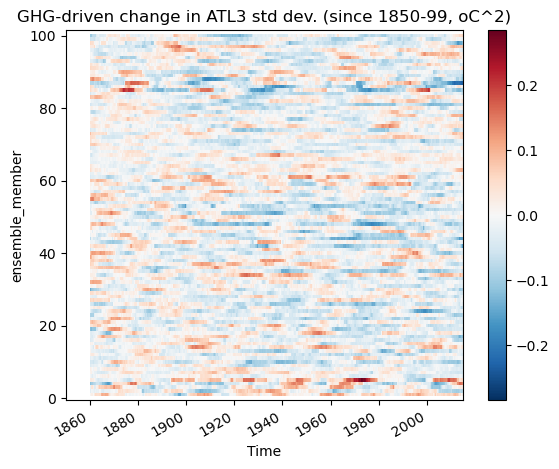

In [10]:
# Compute the running standard deviation
window_size = 120  # Number of months in the running window
running_std = ghg_array.rolling(time=window_size).std()
# convert to anomalies
running_std=running_std-running_std.sel(time=slice('1850-01-01','1899-12-31')).mean(dim='time')
running_std.plot()
plt.title('GHG-driven change in ATL3 std dev. (since 1850-99, oC^2)')